In [7]:
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, Dataset, DataLoader

from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import accuracy_score

from aijack.defense import VIB, KL_between_normals, mib_loss
import torchvision
from torchvision import transforms
import torch.nn.functional as F

In [2]:
dim_z = 256
beta = 1e-3
batch_size = 32
samples_amount = 15


In [3]:
train_data = MNIST("MNIST/.", download=True, train=True)
train_dataset = TensorDataset(
    train_data.train_data.view(-1, 28 * 28).float() / 255, train_data.train_labels
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_data = MNIST("MNIST/.", download=True, train=False)
test_dataset = TensorDataset(
    test_data.test_data.view(-1, 28 * 28).float() / 255, test_data.test_labels
)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [24]:
# encoder = nn.Sequential(
#     nn.Linear(in_features=784, out_features=2 * dim_z),
# )
# decoder = nn.Linear(in_features=dim_z, out_features=10)


# net = VIB(encoder, decoder, dim_z, num_samples=samples_amount)

#---------------------------------------------------------------

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 70)
        self.fc2=nn.Linear(70,10)

    def forward(self, x):
        x = self.fc(x)
        x=F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x


net = Net()
# #---------------------------------------------------------------

# Train the victim
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

net = net.to(device)



opt = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.97)
criterion = nn.CrossEntropyLoss()


for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0
    data_size = 0
    for Data in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        data, label = Data

        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = net(data)
        outputs=outputs
        loss = criterion(outputs, label.to(torch.int64))
        loss.backward()
        opt.step()

        running_loss += loss.item()
        data_size += data.shape[0]

    print(f"epoch {epoch}: loss is {running_loss/data_size}")





epoch 0: loss is 0.050002097441752755
epoch 1: loss is 0.047841641070445376
epoch 2: loss is 0.0473508588095506
epoch 3: loss is 0.047073747285207114
epoch 4: loss is 0.04688881996075312
epoch 5: loss is 0.04673281203111013
epoch 6: loss is 0.046616472671429314
epoch 7: loss is 0.046513241614898046
epoch 8: loss is 0.04644602346817652
epoch 9: loss is 0.04638316799203555
epoch 10: loss is 0.04633481586376826
epoch 11: loss is 0.04628656626145045
epoch 12: loss is 0.046262020508448284
epoch 13: loss is 0.04621639717022578
epoch 14: loss is 0.04618249054551125
epoch 15: loss is 0.04616652866999308
epoch 16: loss is 0.04614240460594495
epoch 17: loss is 0.04611179553071658
epoch 18: loss is 0.046091617476940155
epoch 19: loss is 0.04608036512732506


In [25]:
in_preds = []
in_label = []
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        outputs = net(inputs)
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
print(
    "Test Accuracy is: ",
    accuracy_score(np.array(torch.argmax(in_preds, axis=1)), np.array(in_label)),
)

Test Accuracy is:  0.98215


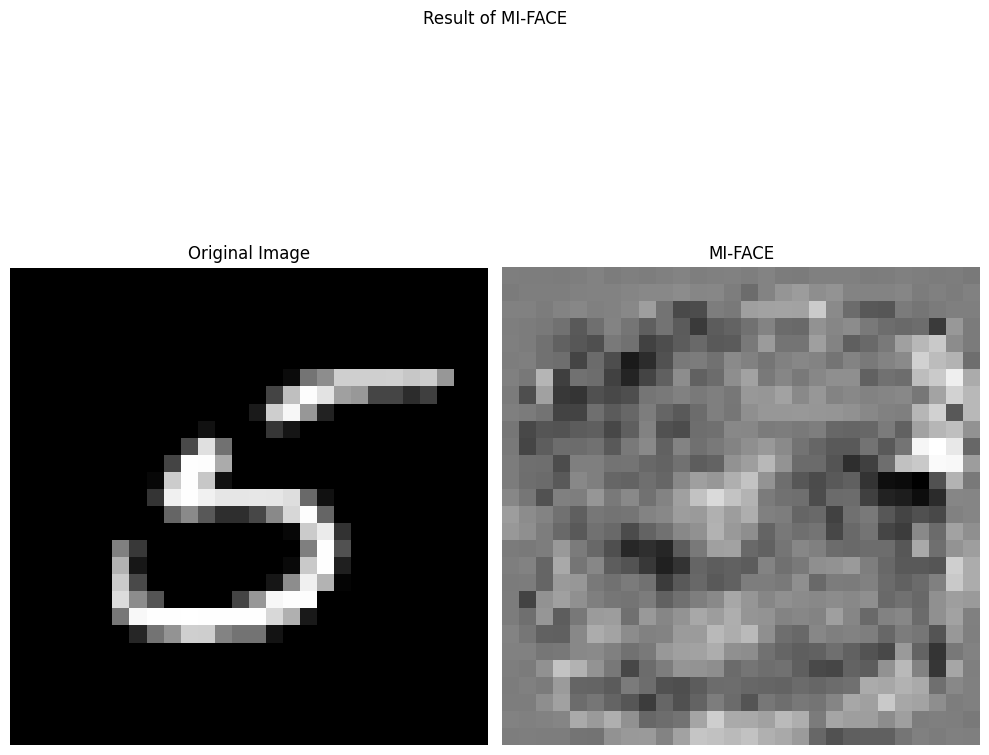

In [28]:

from aijack.attack import MI_FACE
import matplotlib.pyplot as plt

input_shape = (1,28**2)
target_label = 5
lam = 0.1
num_itr = 10000

mi = MI_FACE(
    net,
    input_shape,
    target_label=target_label,
    num_itr=num_itr,
    lam=lam,
    log_interval=0,
)
x_result_1, log = mi.attack()

x_result_1=x_result_1[0].cpu().detach().numpy().reshape(28,28)
ref_img=inputs[0].reshape(28,28).detach().numpy()


#compare the result with the original image
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(ref_img, cmap="gray")
ax1.axis("off")
ax1.set_title("Original Image")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(x_result_1, cmap="gray")
ax2.axis("off")
ax2.set_title("MI-FACE")
plt.suptitle("Result of MI-FACE")
plt.tight_layout()

